In [1]:
!pip install earthengine-api
!pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00


In [2]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import folium

In [3]:
# Authenticate to Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='ee-raj282251')

In [4]:
# Step 2: Define the Region of Interest (ROI) - Ludhiana District, Punjab, India
def get_ludhiana_boundary():
    # Get Ludhiana district boundary from FAO GAUL dataset
    ludhiana = ee.FeatureCollection('FAO/GAUL/2015/level2') \
        .filter(ee.Filter.And(
            ee.Filter.eq('ADM1_NAME', 'Punjab'),
            ee.Filter.eq('ADM2_NAME', 'Ludhiana')
        ))
    return ludhiana

In [5]:
ludhiana = get_ludhiana_boundary()


In [6]:
# Create a map centered on Ludhiana
Map = geemap.Map()
Map.centerObject(ludhiana, 10)
Map.addLayer(ludhiana, {}, 'Ludhiana District')
Map

Map(center=[30.81083188332916, 75.82406946610104], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
def mask_clouds_robust(image):
    """Robust cloud masking function that works with different Sentinel-2 band structures"""
    # Get available bands for this image
    band_names = image.bandNames()

    # Check if QA60 is available (older processing version)
    qa60_mask = ee.Algorithms.If(
        band_names.contains('QA60'),
        # If QA60 exists, use it for cloud masking
        ee.Image(
            image.select('QA60')
            .bitwiseAnd(1 << 10).eq(0)  # Clouds bit
            .And(image.select('QA60').bitwiseAnd(1 << 11).eq(0))  # Cirrus bit
        ),
        # If QA60 doesn't exist, check for MSK bands
        ee.Algorithms.If(
            band_names.contains('MSK_CLASSI_CIRRUS'),
            # If MSK bands exist, use them
            ee.Image(
                image.select('MSK_CLDPRB').lt(20)
                .And(image.select('MSK_CLASSI_CIRRUS').eq(0))
            ),
            # If neither exists, try SCL (which seems to be in both versions)
            ee.Image(
                image.select('SCL')
                .neq(1).And(image.select('SCL').neq(3))
                .And(image.select('SCL').neq(8))
                .And(image.select('SCL').neq(9))
                .And(image.select('SCL').neq(10))
            )
        )
    )

    # Apply mask and scale the data
    return image.updateMask(qa60_mask).select('B.*').divide(10000) \
                .copyProperties(image, ['system:time_start'])

In [8]:
# Get a single image to check its bands
sample_image = ee.ImageCollection('COPERNICUS/S2_SR').first()
print("Available bands:", sample_image.bandNames().getInfo())

Available bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']


In [9]:
def get_sentinel2_composite(roi, start_date, end_date):
    """Get Sentinel-2 composite for specified region and date range"""
    # Get Sentinel-2 Surface Reflectance data
    s2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterDate(start_date, end_date) \
        .filterBounds(roi) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(mask_clouds_robust)

    # Create a median composite
    s2_composite = s2_collection.median().clip(roi)

    return s2_composite

In [10]:
# Define time period for analysis
start_date = '2023-01-01'
end_date = '2023-12-31'

In [11]:
# Get Sentinel-2 composite
s2_composite = get_sentinel2_composite(ludhiana, start_date, end_date)

In [12]:
print(type(s2_composite))


<class 'ee.image.Image'>


In [13]:
# Display the composite in true color
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}
Map.addLayer(s2_composite, vis_params, 'Sentinel-2 Composite')
Map

Map(center=[30.81083188332916, 75.82406946610104], controls=(WidgetControl(options=['position', 'transparent_b…

In [14]:
#  Step 4: Feature Extraction
def calculate_indices(image):
    """Calculate spectral indices for land cover classification"""
    # NDVI (Normalized Difference Vegetation Index)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # NDWI (Normalized Difference Water Index)
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')

    # NDBI (Normalized Difference Built-up Index)
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')

    # Bare Soil Index (BSI)
    bsi = image.expression(
        '((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))',
        {
            'B11': image.select('B11'),
            'B4': image.select('B4'),
            'B8': image.select('B8'),
            'B2': image.select('B2')
        }
    ).rename('BSI')
    # Add indices to the original image
    return image.addBands([ndvi, ndwi, ndbi, bsi])


In [15]:
# Calculate spectral indices
features_image = calculate_indices(s2_composite)

In [16]:
# Select bands for classification (spectral bands + indices)
selected_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'BSI']
features_image = features_image.select(selected_bands)

In [17]:
# Step 5: Training Data Collection
def create_training_points():
    """Create training points for each land cover class"""
    # Class 0: Water bodies
    water = ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point([75.8782, 30.9069]), {'class': 0}),  # Sutlej River
        ee.Feature(ee.Geometry.Point([75.9981, 30.9532]), {'class': 0}),  # Buddha Nallah
        ee.Feature(ee.Geometry.Point([75.8458, 30.9274]), {'class': 0}),  # Canal
        ee.Feature(ee.Geometry.Point([75.7688, 31.0173]), {'class': 0}),  # Reservoir
        ee.Feature(ee.Geometry.Point([75.7882, 30.8529]), {'class': 0})   # Pond
    ])

    # Class 1: Barren land
    barren = ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point([75.6984, 30.9012]), {'class': 1}),
        ee.Feature(ee.Geometry.Point([75.7123, 30.8457]), {'class': 1}),
        ee.Feature(ee.Geometry.Point([75.8901, 30.7823]), {'class': 1}),
        ee.Feature(ee.Geometry.Point([75.9734, 30.8290]), {'class': 1}),
        ee.Feature(ee.Geometry.Point([76.0321, 30.9124]), {'class': 1})
    ])

    # Class 2: Forests
    forest = ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point([75.8123, 30.9456]), {'class': 2}),
        ee.Feature(ee.Geometry.Point([75.9012, 30.9789]), {'class': 2}),
        ee.Feature(ee.Geometry.Point([75.7689, 30.8945]), {'class': 2}),
        ee.Feature(ee.Geometry.Point([75.8423, 30.7890]), {'class': 2}),
        ee.Feature(ee.Geometry.Point([75.9678, 30.8567]), {'class': 2})
    ])

    # Class 3: Built-up areas
    builtup = ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point([75.8571, 30.9002]), {'class': 3}),  # Ludhiana City Center
        ee.Feature(ee.Geometry.Point([75.8327, 30.9199]), {'class': 3}),  # Residential area
        ee.Feature(ee.Geometry.Point([75.8703, 30.8745]), {'class': 3}),  # Industrial area
        ee.Feature(ee.Geometry.Point([75.9032, 30.9087]), {'class': 3}),  # Commercial area
        ee.Feature(ee.Geometry.Point([75.8123, 30.9321]), {'class': 3})   # Transport hub
    ])

    # Class 4: Bare soil/Agricultural land
    baresoil = ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point([75.7234, 30.9578]), {'class': 4}),
        ee.Feature(ee.Geometry.Point([75.9456, 30.9845]), {'class': 4}),
        ee.Feature(ee.Geometry.Point([76.0123, 30.8456]), {'class': 4}),
        ee.Feature(ee.Geometry.Point([75.7890, 30.7789]), {'class': 4}),
        ee.Feature(ee.Geometry.Point([75.6789, 30.9678]), {'class': 4})
    ])

    # Merge all training points
    return water.merge(barren).merge(forest).merge(builtup).merge(baresoil)

In [18]:
# Create training points
training_points = create_training_points()

In [19]:
# Extract features at training points
training_data = features_image.sampleRegions(
    collection=training_points,
    properties=['class'],
    scale=20
)

In [20]:
# Step 6: Export the training data to use locally
task = ee.batch.Export.table.toDrive(
    collection=training_data,
    description='training_data_export',
    fileFormat='CSV'
)
task.start()

In [21]:
def simulate_training_data():
    """Simulate training data for demonstration"""
    # This is a placeholder. In a real workflow, you would use the exported CSV
    # Create random features for demonstration
    n_samples = 25  # 5 samples for each of the 5 classes
    n_features = len(selected_bands)

    # Generate random feature values
    X = np.random.rand(n_samples, n_features)
    # Generate class labels (5 of each class)
    y = np.repeat(np.arange(5), 5)

    return X, y

In [22]:
# Get training data (simulated for demonstration)
X_train, y_train = simulate_training_data()

In [23]:
# Train Gaussian Mixture Model
def train_gmm(X, y, n_components=5):
    """Train a Gaussian Mixture Model for classification"""
    # Create and fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)

    # Map GMM components to classes based on highest probability
    component_labels = np.zeros(n_components, dtype=int)

    # For each class, find which component it most belongs to
    for class_label in np.unique(y):
        class_samples = X[y == class_label]
        probs = gmm.predict_proba(class_samples)
        component_probs = probs.mean(axis=0)
        component_labels[np.argmax(component_probs)] = class_label

    return gmm, component_labels

In [24]:
def train_naive_bayes(X, y):
    """Train a Naive Bayes classifier"""
    nb = GaussianNB()
    nb.fit(X, y)
    return nb

In [25]:
gmm_model, component_labels = train_gmm(X_train, y_train)


In [26]:
# Print information about the trained model
print("GMM Model Training Complete")
print("Number of components:", gmm_model.n_components)
print("Component weights:", gmm_model.weights_)
print("Component means (first 3 features):", gmm_model.means_[:, :3])
print("Component to class mapping:", component_labels)

GMM Model Training Complete
Number of components: 5
Component weights: [0.28 0.08 0.08 0.44 0.12]
Component means (first 3 features): [[0.46304893 0.478592   0.37242709]
 [0.77522377 0.10912559 0.54119228]
 [0.20829083 0.52674918 0.7841226 ]
 [0.46271365 0.52606543 0.49474742]
 [0.66995945 0.37573852 0.93551776]]
Component to class mapping: [2 0 0 4 0]


In [27]:
nb_model = train_naive_bayes(X_train, y_train)


In [28]:
# def classify_image_locally(image, scale=100):
#     """Export image for local classification (for demonstration)"""
#     # Get the Ludhiana boundary
#     ludhiana = get_ludhiana_boundary()

#     # Use the geometry directly but simplify to reduce complexity
#     region = ludhiana.geometry().simplify(maxError=100)

#     # Export the image features to Google Drive for local processing
#     task = ee.batch.Export.image.toDrive({
#         'image': image.select(selected_bands),
#         'description': 'ludhiana_features_export',
#         'folder': 'EarthEngineExports',
#         'scale': scale,
#         'region': region,
#         'fileFormat': 'GeoTIFF'
#     })

#     task.start()
#     print("✅ Exporting image features. Check the Tasks tab in Earth Engine.")


In [29]:
print("Type of features_image:", type(features_image))


Type of features_image: <class 'ee.image.Image'>


In [30]:
print("Image bands:", features_image.bandNames().getInfo())
print("Selected bands:", selected_bands)


Image bands: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'BSI']
Selected bands: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'BSI']


In [31]:
def classify_image_locally(image, scale=100):
    """Export image for local classification (for demonstration)"""
    import ee
    ludhiana = get_ludhiana_boundary()

    # Use a simplified server-side region
    region = ludhiana.geometry().simplify(maxError=100)

    # Just to be 100% sure selected_bands is valid inside function
    available_bands = image.bandNames().getInfo()
    safe_bands = [b for b in selected_bands if b in available_bands]
    print("✅ Bands to export:", safe_bands)

    # Export task
    task = ee.batch.Export.image.toDrive(**{
        'image': image.select(safe_bands),
        'description': 'ludhiana_features_export',
        'folder': 'EarthEngineExports',  # Optional, remove if not needed
        'scale': scale,
        'region': region,
        'fileFormat': 'GeoTIFF'
    })

    task.start()
    print("🚀 Export started! Check the Tasks tab in Earth Engine.")


In [32]:
# Call the function with your image
classify_image_locally(features_image, scale=100)

✅ Bands to export: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'BSI']
🚀 Export started! Check the Tasks tab in Earth Engine.


In [33]:
# Step 9: Visualization and Analysis
# For demonstration, we'll create a classified image with random class values
def visualize_classification():
    """Visualize a simulated classification result"""
    # Create a classified image with 5 classes (simulated)
    # In a real workflow, this would come from your GMM or Naive Bayes classification

    # For demonstration purposes, use a simple threshold classification based on indices
    water = features_image.select('NDWI').gt(0.3)
    vegetation = features_image.select('NDVI').gt(0.5)
    builtup = features_image.select('NDBI').gt(0.1)
    barren = features_image.select('BSI').gt(0.1)
    baresoil = features_image.expression(
        '(NDVI > 0.2 && NDVI < 0.5) || (BSI > 0 && BSI < 0.1)',
        {
            'NDVI': features_image.select('NDVI'),
            'BSI': features_image.select('BSI')
        }
    )

    # Combine into a single classified image
    classified = water.multiply(0) \
        .add(barren.multiply(1)) \
        .add(vegetation.multiply(2)) \
        .add(builtup.multiply(3)) \
        .add(baresoil.multiply(4))

    # Set visualization parameters
    class_vis = {
        'min': 0,
        'max': 4,
        'palette': ['0000FF', 'D3D3D3', '008000', 'FF0000', 'FFFF00']
    }

    # Add the classified image to the map
    Map.addLayer(classified, class_vis, 'Classified LULC (Simulated)')

    return classified

In [34]:
# Create a simulated classified image
classified_image = visualize_classification()
Map

Map(center=[30.81083188332916, 75.82406946610104], controls=(WidgetControl(options=['position', 'transparent_b…

In [35]:
# Step 10: Accuracy Assessment
def assess_accuracy(test_features, test_labels, gmm_model, nb_model, component_labels):
    """Assess classification accuracy (simulated)"""
    # Predict using GMM
    gmm_pred_probs = gmm_model.predict_proba(test_features)
    gmm_pred_components = gmm_model.predict(test_features)
    gmm_predictions = np.array([component_labels[comp] for comp in gmm_pred_components])

    # Predict using Naive Bayes
    nb_predictions = nb_model.predict(test_features)

    # Calculate accuracy
    gmm_accuracy = accuracy_score(test_labels, gmm_predictions)
    nb_accuracy = accuracy_score(test_labels, nb_predictions)

    print(f"GMM Accuracy: {gmm_accuracy:.2f}")
    print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}")

    # Create confusion matrices
    gmm_cm = confusion_matrix(test_labels, gmm_predictions)
    nb_cm = confusion_matrix(test_labels, nb_predictions)

    # Print classification reports
    print("\nGMM Classification Report:")
    print(classification_report(test_labels, gmm_predictions))

    print("\nNaive Bayes Classification Report:")
    print(classification_report(test_labels, nb_predictions))

    # Create visualization of confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # GMM confusion matrix
    axes[0].imshow(gmm_cm, cmap=plt.cm.Blues)
    axes[0].set_title('GMM Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Naive Bayes confusion matrix
    axes[1].imshow(nb_cm, cmap=plt.cm.Blues)
    axes[1].set_title('Naive Bayes Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [36]:
# Simulate test data for accuracy assessment
X_test, y_test = simulate_training_data()

GMM Accuracy: 0.16
Naive Bayes Accuracy: 0.20

GMM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.19      0.80      0.31         5

    accuracy                           0.16        25
   macro avg       0.04      0.16      0.06        25
weighted avg       0.04      0.16      0.06        25


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.22      0.40      0.29         5
           2       0.12      0.20      0.15         5
           3       1.00      0.20      0.33         5
           4       0.20      0.20      0.20         5

    accuracy                           0.20        25
   macro avg       0.

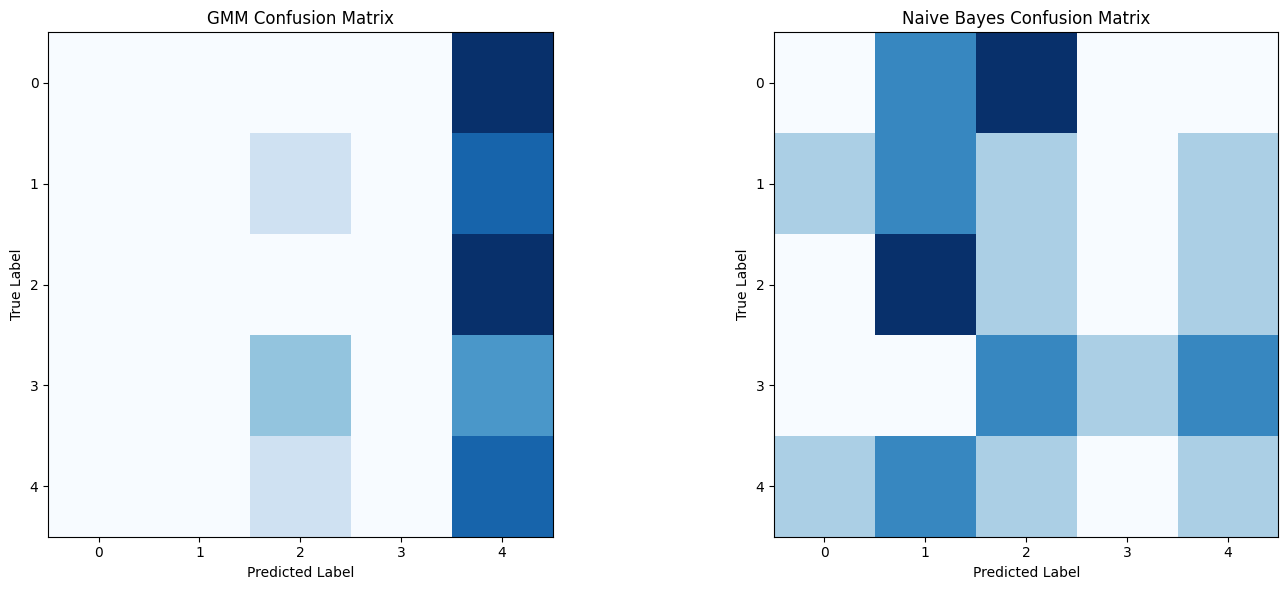

In [37]:
# Assess accuracy with simulated data
assess_accuracy(X_test, y_test, gmm_model, nb_model, component_labels)

In [38]:
# Step 11: Final Map Composition and Export
def create_final_map():
    """Create final map composition with legend"""
    # Add a legend to the map
    class_names = ['Water', 'Barren Land', 'Forest', 'Built-up', 'Bare Soil']
    colors = ['#0000FF', '#D3D3D3', '#008000', '#FF0000', '#FFFF00']

    Map.add_legend(title="LULC Classes",
                   legend_dict=dict(zip(class_names, colors)))

    # Add a title with a valid position
    Map.add_text(
        text='Land Use Land Cover Classification of Ludhiana, Punjab (2023)',
        font_size=24,
        position='topleft'  # Valid position
    )

    return Map  # Create final map with legend

final_map = create_final_map()


In [39]:
# Create final map with legend
# final_map = create_final_map()
final_map

Map(center=[30.81083188332916, 75.82406946610104], controls=(WidgetControl(options=['position', 'transparent_b…

In [43]:
def export_classified_image(classified):
    """Export the classified image to Google Drive"""

    # Just double-check the type
    print("Exporting image of type:", type(classified))

    # Change from dictionary format to keyword arguments format
    task = ee.batch.Export.image.toDrive(
        image=classified,
        description='ludhiana_lulc_classified',
        scale=30,
        region=ludhiana.geometry(),
        fileFormat='GeoTIFF'
    )
    task.start()

    print("Exporting classified image. Please wait for the export to complete...")
    print("Check the Tasks tab in Google Earth Engine to download the classified image.")

In [44]:
# Example of ensuring classified_image is an ee.Image
classified_image = classified_image.clip(ludhiana)  # Ensure the classification is within bounds

# Print type just to be sure
print("Type of classified_image:", type(classified_image))

Type of classified_image: <class 'ee.image.Image'>


In [45]:
# Export the classified image
export_classified_image(classified_image)

Exporting image of type: <class 'ee.image.Image'>
Exporting classified image. Please wait for the export to complete...
Check the Tasks tab in Google Earth Engine to download the classified image.


In [46]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.9 MB/s eta 0:00:00


In [47]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the exported GeoTIFF
image_path = "/content/drive/MyDrive/EarthEngineExports/ludhiana_features_export.tif"  # Replace with your local file path
with rasterio.open(image_path) as src:
    image_data = src.read()# shape (bands, rows, cols)
    transform = src.transform
    metadata = src.meta
# Check the shape of the image
print(f"Image shape (bands, rows, cols): {image_data.shape}")




Image shape (bands, rows, cols): (13, 511, 1108)


In [48]:
# Flatten the image data
# Reshape the image data from (bands, rows, cols) to (rows*cols, bands)
image_data_flattened = image_data.reshape((image_data.shape[0], -1)).T  # shape (rows*cols, bands)

# Check the shape of the flattened data
print(f"Flattened data shape: {image_data_flattened.shape}")


Flattened data shape: (566188, 13)


In [49]:
from sklearn.impute import SimpleImputer

# Create an imputer object to replace NaNs with the mean of each column (band)
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the flattened data
image_data_imputed = imputer.fit_transform(image_data_flattened)

# Check for NaNs after imputation
print(f"Are there any NaNs after imputation? {np.isnan(image_data_imputed).any()}")


Are there any NaNs after imputation? False


In [51]:
# Example labels (replace with your actual class labels)
# Each pixel should have a class label (e.g., 0 for water, 1 for forest, etc.)
y = np.random.randint(0, 5, size=(image_data_imputed.shape[0]))  # Random labels for illustration

# Alternatively, you should load your actual labels for classification


In [52]:
# Remove rows containing NaN values
X_no_nan = image_data_flattened[~np.isnan(image_data_flattened).any(axis=1)]

# Assuming `y` contains your labels, remove corresponding labels with NaNs
y_no_nan = y[~np.isnan(image_data_flattened).any(axis=1)]

print(f"Shape of cleaned data: {X_no_nan.shape}")


Shape of cleaned data: (419234, 13)


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data_imputed, y, test_size=0.2, random_state=42)

# Create and train the Naive Bayes classifier
model = GaussianNB()
model.fit(X_train, y_train)

# Evaluate the model accuracy on the test set
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 19.74%


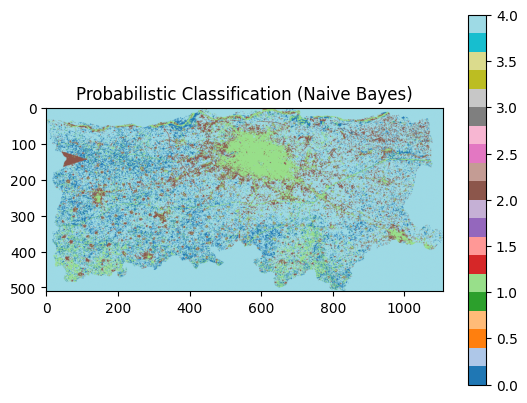

In [54]:
# Predict the class for every pixel in the image
predictions = model.predict(image_data_imputed)

# Reshape the predictions back to the image dimensions
predicted_image = predictions.reshape(image_data.shape[1], image_data.shape[2])

# Plot the classified image
plt.imshow(predicted_image, cmap='tab20')  # Use a color map for better visualization
plt.title("Probabilistic Classification (Naive Bayes)")
plt.colorbar()
plt.show()


In [55]:
import rasterio
from rasterio.transform import from_origin

# Update metadata for output file (same as input image)
metadata.update({
    'dtype': 'int16',  # Set the data type to integer for class labels
    'count': 1,        # Single band for the classification result
})

# Output path for the classified image
output_path = "classified_probabilistic_output.tif"

# Save the predictions as a GeoTIFF
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(predicted_image, 1)

print(f"Predictions saved to {output_path}")


Predictions saved to classified_probabilistic_output.tif


In [56]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate accuracy
accuracy_rf = model_rf.score(X_test, y_test)
print(f"Random Forest Model Accuracy: {accuracy_rf * 100:.2f}%")


Random Forest Model Accuracy: 20.02%
